In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.hedging_utils as hu
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [54]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
mu=0.1
sigma = 0.2
q = 0
T = 20/52 
K = 50
type = 'c'
M=1000
N=1

In [55]:
np.seterr(divide='ignore')
T_array = np.linspace(T, 0, M)
dt = T_array[1] - T_array[2]
S = hu.simulate_gbm(S0, T_array, sigma, mu, q, M)
bs_price_array = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type, display_result=False)*(-option_exposure)
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)

hedging_df = pd.DataFrame(zip(S, delta_array, bs_price_array), columns=['Stock_Price', 'Delta', 'BS_Price'])
hedging_df['Stock_Price_Change'] = hedging_df['Stock_Price'].sub(hedging_df['Stock_Price'].shift())
hedging_df['Shares_Held'] = -option_exposure*hedging_df['Delta']
hedging_df['Total_Stock_Position'] = hedging_df['Shares_Held']*hedging_df['Stock_Price']
hedging_df['Money_Market_Position'] = np.nan
hedging_df['Money_Market_Position'].iloc[0] = hedging_df['BS_Price'].iloc[0] - hedging_df['Total_Stock_Position'].iloc[0]
hedging_df['Interest'] = np.nan
hedging_df['Interest'].iloc[0] = 0
hedging_df['Hedging_Portfolio_Value'] = hedging_df['Total_Stock_Position'] + hedging_df['Money_Market_Position']

for i in range(1, len(T_array)):
    hedging_df['Interest'].iloc[i] = hedging_df['Money_Market_Position'].iloc[i-1]*r*dt
    hedging_df['Hedging_Portfolio_Value'].iloc[i] = hedging_df['Hedging_Portfolio_Value'].iloc[i-1] + hedging_df['Shares_Held'].iloc[i-1]*hedging_df['Stock_Price_Change'].iloc[i] + hedging_df['Interest'].iloc[i]
    hedging_df['Money_Market_Position'].iloc[i] = hedging_df['Hedging_Portfolio_Value'].iloc[i] - hedging_df['Total_Stock_Position'].iloc[i]
hedging_df['Delta_Hedge_Portfolio_Value'] = hedging_df['Hedging_Portfolio_Value'].sub(hedging_df['BS_Price'])
hedging_df['Hedge_Portfolio_PnL'] = hedging_df['Delta_Hedge_Portfolio_Value'].sub(hedging_df['Delta_Hedge_Portfolio_Value'].shift())
hedging_df['Portfolio_Gamma_Contribution'] = 1/2*gamma_array*option_exposure*hedging_df['Stock_Price_Change']**2
hedging_df['Portfolio_Theta_Contribution'] = theta_array*option_exposure*dt

hedging_df

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma/(2*np.sqrt(T))


,Stock_Price,Delta,BS_Price,Stock_Price_Change,Shares_Held,Total_Stock_Position,Money_Market_Position,Interest,Hedging_Portfolio_Value,Delta_Hedge_Portfolio_Value,Hedge_Portfolio_PnL,Portfolio_Gamma_Contribution,Portfolio_Theta_Contribution
0,49.000000,5.216047e-01,2.400527e+05,NaN,5.216047e+04,2.555863e+06,-2.315810e+06,0.000000,240052.732327,-2.328306e-10,NaN,NaN,1.657554e+02
1,48.975022,5.198903e-01,2.385863e+05,-0.024978,5.198903e+04,2.546164e+06,-2.307458e+06,-44.579389,238705.272950,1.189694e+02,118.969417,-2.047224e+00,1.656229e+02
2,49.147390,5.311017e-01,2.474780e+05,0.172369,5.311017e+04,2.610226e+06,-2.362604e+06,-44.418619,247622.134552,1.441522e+02,25.182812,-9.702100e+01,1.669535e+02
3,49.327761,5.427800e-01,2.569953e+05,0.180371,5.427800e+04,2.677412e+06,-2.420256e+06,-45.480176,257156.192745,1.608608e+02,16.708525,-1.056150e+02,1.682385e+02
4,49.168569,5.323438e-01,2.482699e+05,-0.159192,5.323438e+04,2.617458e+06,-2.368989e+06,-46.589976,248468.956295,1.990327e+02,38.171946,-8.278178e+01,1.672217e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,47.125998,2.560283e-14,1.215692e-10,-0.013442,2.560283e-09,1.206559e-07,1.158270e+03,0.022296,1158.270346,1.158270e+03,0.022296,-4.788373e-12,9.087319e-10
996,47.013195,7.144107e-20,2.462606e-16,-0.112803,7.144107e-15,3.358673e-13,1.158293e+03,0.022297,1158.292643,1.158293e+03,0.022297,-1.302635e-15,3.490949e-15
997,46.789342,3.289996e-33,7.049718e-30,-0.223853,3.289996e-28,1.539368e-26,1.158315e+03,0.022297,1158.314940,1.158315e+03,0.022297,-3.819322e-28,2.572622e-28
998,46.806084,9.638933e-64,1.045421e-60,0.016742,9.638933e-59,4.511607e-57,1.158337e+03,0.022298,1158.337238,1.158337e+03,0.022298,-1.240971e-60,1.494540e-58


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Hedging PnL: $1158.3595359090896


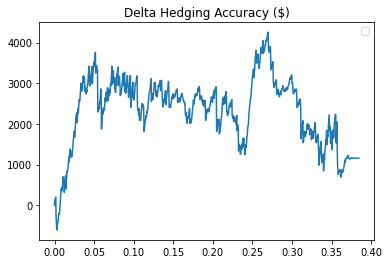

In [56]:
# Plot Delta-Hedge PnL
hedging_pnl = hedging_df['Delta_Hedge_Portfolio_Value'].iloc[-1]
print(f'Hedging PnL: ${hedging_pnl}')
plt.plot(np.flip(T_array), hedging_df['Delta_Hedge_Portfolio_Value'])
plt.legend()
plt.title('Delta Hedging Accuracy ($)')
#plt.ylim(-1, 1)
plt.show()


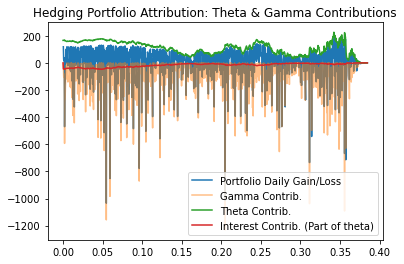

In [57]:
# Plot Delta-Hedge PnL
plt.plot(np.flip(T_array), hedging_df['Hedge_Portfolio_PnL'], label='Portfolio Daily Gain/Loss')
plt.plot(np.flip(T_array), hedging_df['Portfolio_Gamma_Contribution'], alpha=0.5, label='Gamma Contrib.')
plt.plot(np.flip(T_array), hedging_df['Portfolio_Theta_Contribution'], label='Theta Contrib.')
plt.plot(np.flip(T_array), hedging_df['Interest'], label='Interest Contrib. (Part of theta)')

plt.legend()
plt.title('Hedging Portfolio Attribution: Theta & Gamma Contributions')
plt.show()


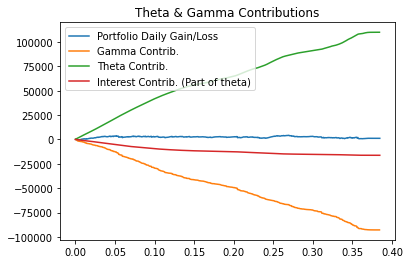

In [58]:
# Plot Delta-Hedge PnL
plt.plot(np.flip(T_array), hedging_df['Hedge_Portfolio_PnL'].cumsum(), label='Portfolio Daily Gain/Loss')
plt.plot(np.flip(T_array), hedging_df['Portfolio_Gamma_Contribution'].cumsum(), label='Gamma Contrib.')
plt.plot(np.flip(T_array), hedging_df['Portfolio_Theta_Contribution'].cumsum(), label='Theta Contrib.')
plt.plot(np.flip(T_array), hedging_df['Interest'].cumsum(), label='Interest Contrib. (Part of theta)')

plt.legend()
plt.title('Theta & Gamma Contributions')
plt.show()
